In [ ]:
%pip install einops
%pip install timm 
%pip install tqdm
%pip install matplotlib
%pip install opencv-python
%pip install -U albumentationsx

In [30]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
from data_processing_and_augmentation import ImageFolderDataset, get_augmentation_pipeline
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

Using device: cpu


In [15]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [16]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

In [17]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [18]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [19]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [26]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    #torch.to(device).manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [50]:
def train(batch_size: int=64,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,  
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = ImageFolderDataset(
    root_dir="data_raw",
    transforms=get_augmentation_pipeline(image_size=(32, 32))
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=True
    )

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET(
        input_channels=3,
        output_channels=3
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):

            x = x.to(device)
            t = torch.randint(0, num_time_steps, (batch_size,), device=x.device)
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size, 1, 1, 1).to(x.device)
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(checkpoint, "checkpoints/ddpm_checkpoint")

In [51]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET(input_channels=3, output_channels=3).to(device)
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 3, 32, 32).to(device)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.to(device),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.to(device),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach().cpu()
            x = x.clamp(0, 1).numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

Epoch 1/5: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


Epoch 1 | Loss 0.00113


Epoch 2/5: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


Epoch 2 | Loss 0.00112


Epoch 3/5: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


Epoch 3 | Loss 0.00110


Epoch 4/5: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


Epoch 4 | Loss 0.00109


Epoch 5/5: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


Epoch 5 | Loss 0.00108


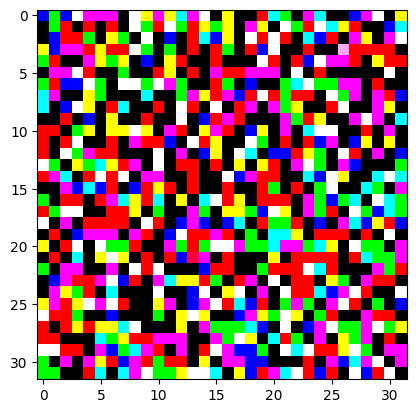

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5401876..2.9967513].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-66.35366..63.35489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-176.15454..166.2736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-381.69647..346.9075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-560.8737..501.58908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-742.5593..654.5066].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-891.9153..771.3

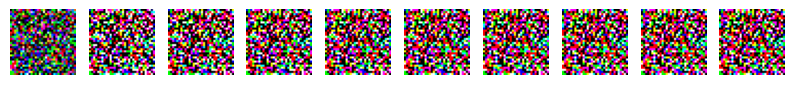

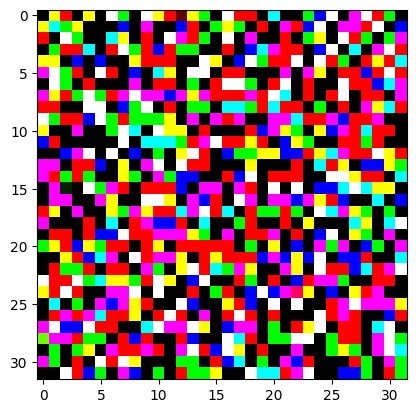

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.599273..3.2732656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-72.86922..63.03432].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-206.36845..165.81859].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-459.65424..348.7273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-683.4102..502.7609].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-913.1767..655.37994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1100.307..771.1

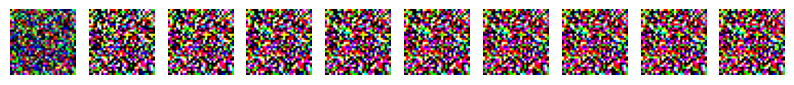

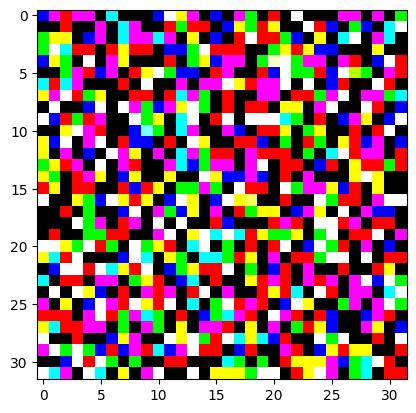

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.080418..4.4321594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-69.62549..68.515656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-200.4896..170.55048].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-446.6209..347.12643].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-663.6063..489.19733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-888.21326..626.37524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1071.815..726

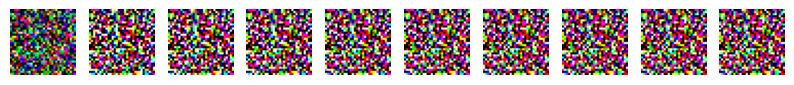

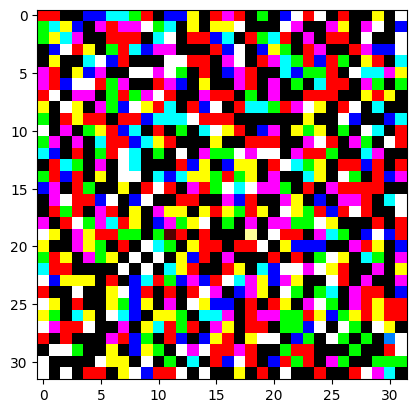

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2644942..3.2262952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-66.21968..63.966995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-184.76562..165.9891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-407.8425..341.80014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-604.43567..483.26425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-805.41016..622.6728].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-968.62933..7

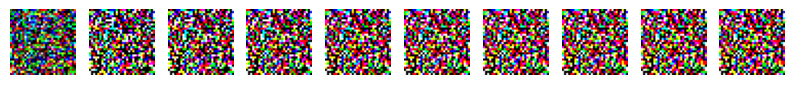

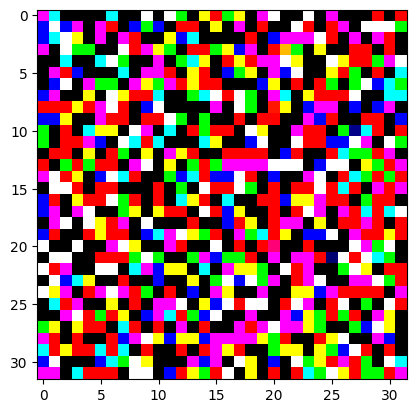

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7641919..3.5626638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-85.848015..57.236305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-234.27829..156.3929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-501.45728..334.05246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-727.0549..486.39362].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-952.12427..639.325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1125.3901..7

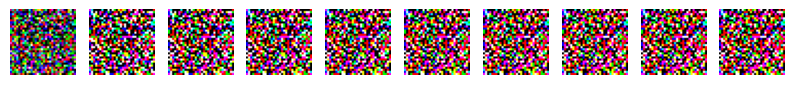

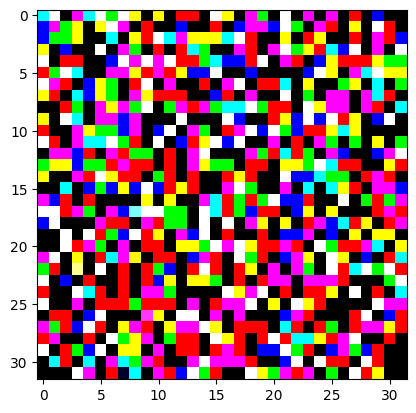

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5210233..3.1512458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-96.63073..63.10768].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-247.57733..173.11174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-515.5595..377.21085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-740.715..555.24384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-960.9609..735.0641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1128.1742..879.

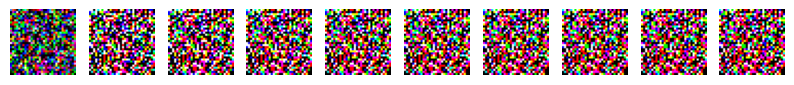

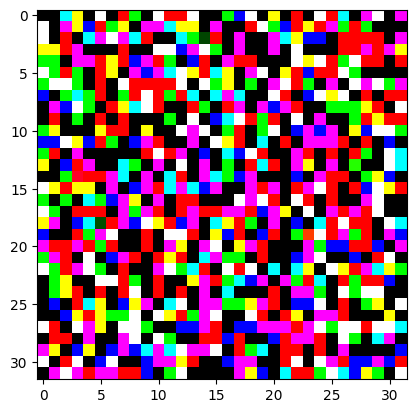

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.05836..3.609812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-70.972206..57.800087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-188.59663..147.16652].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-400.17456..301.19073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-578.52747..437.0085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-755.59955..571.13184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-900.2556..67

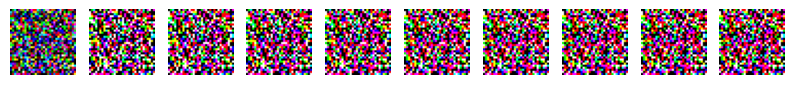

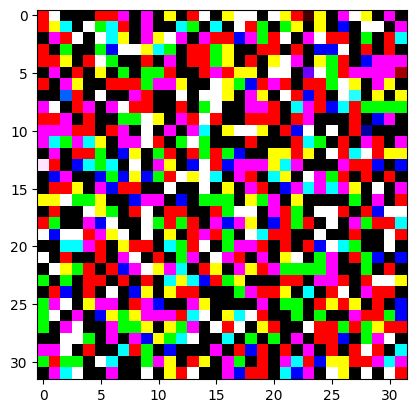

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7061038..3.7171443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-70.77661..70.44851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-191.60208..173.05307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-405.57016..346.37698].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-588.71075..482.35608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-771.9175..610.6941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-914.5808..70

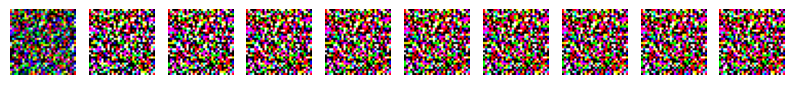

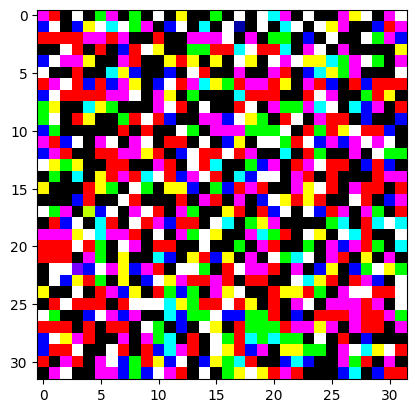

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4495423..3.3240902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-85.72965..59.22376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-219.37727..154.98146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-456.28387..321.74564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-654.05695..463.0136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-846.17725..602.64014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-990.5938..7

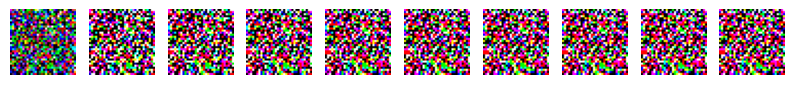

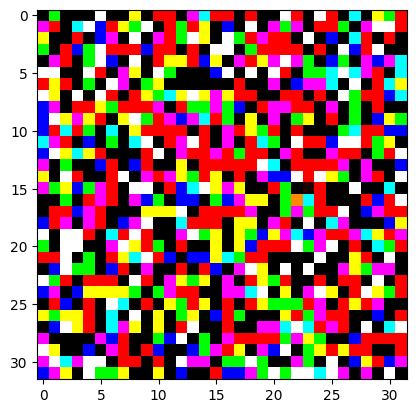

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2320378..3.579549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-68.32288..60.017437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-188.38321..166.97427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-408.63297..359.79614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-596.9685..525.78217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-792.83154..692.2378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-957.5352..82

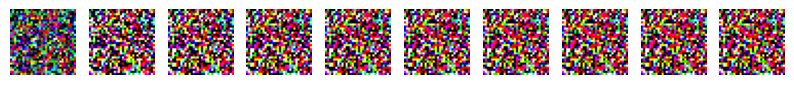

In [52]:
def main():
    train(checkpoint_path=None, lr=2e-5, num_epochs=5)

    # Run inference only if checkpoint exists
    import os
    if os.path.exists("checkpoints/ddpm_checkpoint"):
        inference("checkpoints/ddpm_checkpoint")
    else:
        print("Checkpoint not found — skipping inference.")

# In Jupyter, just call:
main()